# **Machine Learning Nanodegree Capstone Project: Vehicle Detection and Tracking**

---

** Project Overview **

The purpose of this project is to accurately identify vehicles in a video. To achive this coputer vision and machine learning techniques are used in conjuction. 

The problem at hand is the identification and classification of vehicles in an image. The solution to the problem should be able to segment relevant objects in an image in order to accurately identify a vehicle in a image. As for quantification of the proposed solution we could measure the accuracy of the classifier with the training and testing data as well as the percentage of vehicles classified correctly in a given number of images. The project and results should be replicable using the same image dataset.

The implementation of this project will be done in the following seven parts:
- Part 1: HOG Feature Extraction
- Part 2: Train a Linear SVM classifier
- Part 3: Add Color Features
- Part 4: Re-Train the Linear SVM classifier
- Part 5: Sliding Window Search
- Part 6: Search and Classify an Image
- Part 7: Search and Classify a Video

This notebook focuses on the just implementation of the project. For a more indepth explination of the project, methods used, and results please read the Project Report.




# **Part 1: HOG Feature Extraction** 
---

The first part showcases the implementation of a Histogram of Gradients
(HOG) Feature extraction. We will use a test image as input in order to demonstrate how it can be converted into a set of features and show a visual representation of the features.

But first lets import the libraries that we will need for our implementation.

In [1]:
#import some useful packages
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import os
from sklearn.cross_validation import train_test_split

Now let write a function that applies a **HOG feature extraction** on a image and returns those features

In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

Now we want to see an unaltered image that we will use for our feature extraction, and then we will display the resulting visualization of the HOG feature extraction

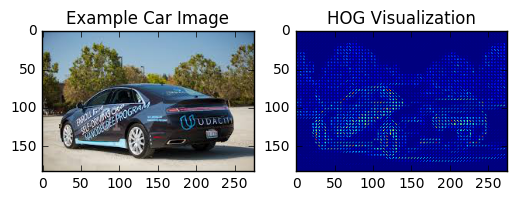

In [3]:
%matplotlib inline
image = mpimg.imread('test_image.jpeg')

#printing out some stats and plotting
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 4
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image)
plt.title('HOG Visualization')
type(hog_image)
mpimg.imsave("RESULT_hog_image", hog_image)

Comparing the two images, we can see that the car is still very identifiable in the HOG Visualization. 

Now that we have succesfully created a **HOG visualization** of our test image, we will apply this to our labaeled training data. After getting the HOG transfrom for the dataset we will use it to train  a **Linear SVM classifier**.

--- 

In [4]:
cars = []
not_cars = []
features = []

# Get the images from the directory. 
# Divide up into cars and notcars
for folder in os.listdir('vehicles'):
    if not (folder == '.DS_Store'):
        for file in os.listdir('vehicles/'+folder):
            if '.png' in file:
                cars.append(str('vehicles/'+folder+'/'+file))
            
for folder in os.listdir('non-vehicles'):
    if not (folder == '.DS_Store'):
        for file in os.listdir('non-vehicles/'+folder):
            if '.png' in file:
                not_cars.append(str('non-vehicles/'+folder+'/'+file))

Now that we have the image dataset available, we will define a function to extract the HOG features of an array of images.

In [5]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_hog_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    images = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        #image = mpimg.imread('test_image.jpeg')
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=True, feature_vec=True
        hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)

        # Append the new feature vector to the features list
        features.append(hog_features)
        images.append(hog_image)
        
    # Return list of feature vectors, and image visualizaiton
    return (features, images)

In this next cell, we apply our newly defined function to out car and non-car image dataset, to extract the features, wich we will then use to train our classifier.

**NOTE:** For this next few cell we will only use a small subset of the available image dataset beacuse using all of it would be time consuming and impractical. We will use the intire dataset when we retrain the classifier in Part 4.

In [8]:
car_features, car_images = extract_hog_features(cars[0:40], cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
notcar_features, not_car_images = extract_hog_features(not_cars[0:40], cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))


Now that the features have been extracted, lets see the result of our efforts this far.

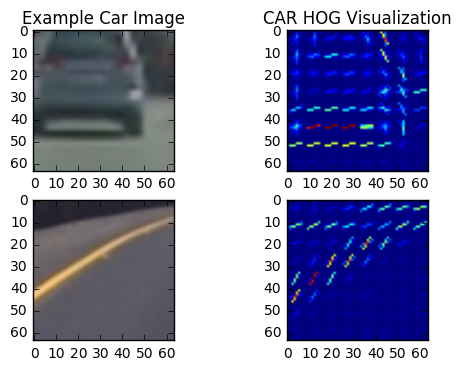

In [9]:
index = 9
image = mpimg.imread(cars[index])
image2 = mpimg.imread(not_cars[index])

fig = plt.figure()
plt.subplot(221)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')

plt.subplot(222)
plt.imshow(car_images[index])
plt.title('CAR HOG Visualization')

plt.subplot(223)
plt.imshow(image2, cmap='gray')

plt.subplot(224)
plt.imshow(not_car_images[index])

The images above are useful in helping us visualize the difference in features from a labeled car image and a non-car image.

The next step is to ***train our machine learning classifier*** with just the HOG visualization features, and test its accuracy. 

# **Part 2: Train a Linear SVM classifier** 
---

Using the features extracted from the car and non-car datasets in the
previous part we will train a Support Vector Machine (SVM) classifier. Then the accuracy of the classifier will be tested on the training and testing data.

A Linear SVM was chosen over other classifers because of its simplicity. 

In [10]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(t2-t, 'Seconds to train SVC...')

# Check the score of the SVC
print('Train Accuracy of SVC = ', svc.score(X_train, y_train))
print('Test Accuracy of SVC = ', svc.score(X_test, y_test))
# Check the prediction time for a single sample
t=time.time()
prediction = svc.predict(X_test[0].reshape(1, -1))
t2 = time.time()
print(t2-t, 'Seconds to predict with SVC')

0.05244708061218262 Seconds to train SVC...
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  1.0
0.023901939392089844 Seconds to predict with SVC


**NOTE:** The above results may not be comparable to those of Part 4 if the entire data-set was not used for both test.

# ** Part 3: Add Color Features** 
---

In this part further features will be extracted. In the features come from the
color of the image rather than the gradient. Features from all of the images in the dataset will be extracted and combined with the HOG features.

In [11]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    #print(img.shape)
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

The following cell is a function definition very similar to the 'extact_hog_features' defined earlier in this project. However this function extract Color features as well as the previous hog features and returnes a combined set of features.

In [12]:
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=4, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    images = []
    i = 1
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Call get_hog_features() with vis=False, feature_vec=True
        hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
     
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
        images.append(hog_image)
        
    # Return list of feature vectors
    return (features, images)        

The feature extraction for the entire image dataset takes place in the next cell. The dataset contains 11268, so running the next cell will take a while... It the features have been extracted before, skip the next two cells.

In [24]:
t = time.time()

car_features, car_images = extract_features(cars[:1000], cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))

t2 = time.time()
print(t2-t, 'Time to extract car features')

notcar_features, car_images = extract_features(not_cars[:1000], cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))

t3 = time.time()
print(t3-t2, 'Time to extract non-car features')
print(t3-t, 'Total time to extract features')

97.29330706596375 Time to extract car features
96.21359086036682 Time to extract non-car features
193.50689792633057 Total time to extract features


# ** Part 4: Re-Train a Linear SVM classifier** 
---

The classifier from Part 2 will now be retrained with the combined HOG
and Color features. Once again the accuracy of the classifier will be tested on the training and testing data.

In [25]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

# Use a linear SVC 
svc = LinearSVC()

In [26]:
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(t2-t, 'Seconds to train SVC...')

0.7911920547485352 Seconds to train SVC...


In [27]:
# Check the score of the SVC
print('Train Accuracy of SVC = ', svc.score(X_train, y_train))
print('Test Accuracy of SVC = ', svc.score(X_test, y_test))
# Check the prediction time for a single sample
t=time.time()
prediction = svc.predict(X_test[0].reshape(1, -1))
t2 = time.time()
print(t2-t, 'Seconds to predict with SVC')

Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.9975
0.00024008750915527344 Seconds to predict with SVC


In [30]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets

# import some data to play with
#iris = datasets.load_iris()
#X = iris.data[:, :2]  # we only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset
#y = iris.target

h = .02  # step size in the mesh

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
svc = svm.SVC(kernel='linear', C=C).fit(X, y)

# create a mesh to plot in
x_min, x_max = X.min() - 1, X.max() + 1
y_min, y_max = X.min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['LinearSVC (linear kernel)']


# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
#plt.subplot(2, 2, i + 1)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
#Z = Z.reshape(xx.shape)
#plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
#plt.xlim(xx.min(), xx.max())
#plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title(titles[0])

plt.show()

Automatically created module for IPython interactive environment


ValueError: X.shape[1] = 2 should be equal to 11268, the number of features at training time

# **Part 5: Sliding Window Search** 
---

This part focuses on segmenting a large image into smaller more practical
images in order to search for vehicles. This will result in a set of windows from which images will be extracted to then be classified.

In [15]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('bbox-example-image.jpg')
#image = mpimg.imread('test_image.jpeg')

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0,100,0), thick=2):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color , thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

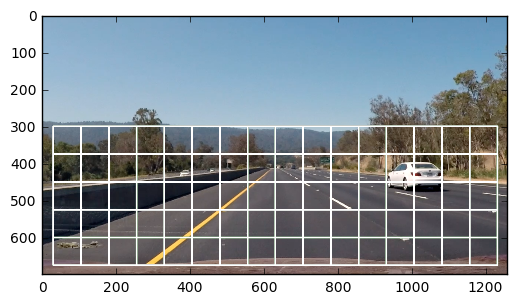

In [16]:
windows = slide_window(image, x_start_stop=[30, None], y_start_stop=[300, None], 
                    xy_window=(150, 150), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 100, 0), thick=3)                    
plt.imshow(window_img)

Now we want to search our image using the sliding window technique and identify if a bounding box contains a car.

# **Part 6: Search and Classify on Image ** 
---

Here all the previous parts come together to achieve vehicle detection in a
single image. This image will be a single frame of the “dash cam” source video. A sliding window search will be used to break down the image into more manageable images than will then be resized in order to be classified properly. If the classifier predicts that there is in fact a car in the image a bounding box will be drawn around the car.

In [17]:
image = mpimg.imread('bbox-example-image.jpg')
image = cv2.convertScaleAbs(image)

box = 6

windows = slide_window(image, x_start_stop=[20, None], y_start_stop=[350, None], 
                    xy_window=(170, 170), xy_overlap=(.5, .5))
                       
window_img = draw_boxes(image, windows, color=(0, 200, 0), thick=6)                    
 
color = (0,255,100)
thick = 5
#test = cv2.rectangle(window_img, windows[0][0], windows[0][1], (95, 99, 159) , thick)


In [18]:
# This function is similar to the previous extract_features but it takes only a single image as input
#def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
#                        hist_bins=32, hist_range=(0, 256), orient=9, 
#                        pix_per_cell=8, cell_per_block=2, hog_channel=0):

def extract_features_single_image(img, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=4, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    images = []
    #plt.imshow(img)

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    else: feature_image = np.copy(img)   
    
    
    # Apply bin_spatial() to get spatial color features
    #feature_image cv2.resize(tmp_image, (64, 64))
    feature_image = feature_image[:,:,:3]
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    #print ('spatial_features', len(spatial_features))
    # Apply color_hist() also with a color space option now
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    # Call get_hog_features() with vis=False, feature_vec=True
    #print ('hist_features', len(hist_features))
    #feature_image = cv2.cvtColor(resized, cv2.COLOR_RGB2GRAY)
    #plt.imshow(feature_image)
    hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    #print ('hog_features', len(hog_features))
    #plt.imshow(hog_image)
    #
    #features, hog_image = get_hog_features(gray, orient, 
    #                pix_per_cell, cell_per_block, 
    #                vis=True, feature_vec=False)
    # Append the new feature vector to the features list
    features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    images.append(hog_image)
    # Return list of feature vectors
    return (features, images)        

In [19]:
window_sizes = [100,150,200]
windows = []

for size in window_sizes:
    windows.append(slide_window(image, x_start_stop=[30, None], y_start_stop=[350, None], 
                        xy_window=(size, size), xy_overlap=(.5, .5)))

In [20]:
# This function will take and image and an array of windows, and a classifier
# Then, using the classifier it will check if there is a car on each window,
# if car is identified then a bounding box will be drawn around that window.
global clf
global win
win = windows
clf = svc
def check_for_car(image):
    features = []
    hog_images = []
    resized_images = []
    bboxes = []
    result = np.copy(image)
    car_count = 0
    notcar_count = 0
    #For each window set
    for window_set in win:
        # For each window
        for wnd in window_set:
            # Retrieve the x,y coundinates from the window
            #print (wnd)
            y1 = wnd[0][0] 
            x1 = wnd[0][1] 
            y2 = wnd[1][0] 
            x2 = wnd[1][1] 

            #save the window image
            tmp_image = image[x1:x2, y1:y2]
            #resize the image to 64 x 64
            resized = cv2.resize(tmp_image, (64, 64), interpolation = cv2.INTER_AREA)

            feat, img = extract_features_single_image(resized, cspace='RGB', spatial_size=(32, 32),
                            hist_bins=32, hist_range=(0, 256))

            features.append(feat)
            hog_images.append(img)
            resized_images.append(resized)


            # Make a prediction with the features for the current window image.
            # If the prediction is true, then draw a bounding bow over the window.
            prediction = svc.predict(feat[0].reshape(1, -1))
            if (prediction):
                bboxes.append(wnd)
                car_count = car_count + 1
            else:
                notcar_count = notcar_count + 1 
                
    window_img = draw_boxes(image, bboxes, color=(0, 100, 0), thick=2) 
    
    print (car_count)
    print (notcar_count)
    
    plt.imshow(window_img)
    
    #return (window_img, features, hog_images, resized_images)
    return (window_img)

10
172


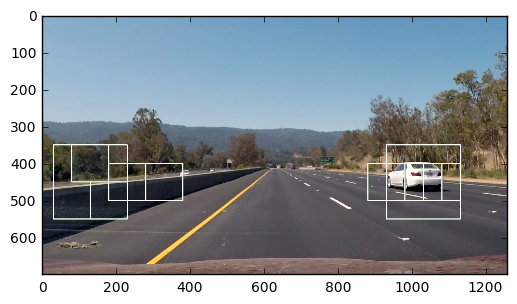

In [21]:

result = check_for_car(image)


# **Part 7: Search and Classify on Video ** 
---

This last part is very similar to Part 6, with the exception that the the
search and classification will be applied to each frame of the source video and the result will be a copy of the source video but with the vehicles identified by bounding boxes.

In [22]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

9
173
[MoviePy] >>>> Building video result_video.mp4
[MoviePy] Writing video result_video.mp4


  0%|          | 1/201 [00:21<1:10:50, 21.25s/it]

9
173


  1%|          | 2/201 [00:41<1:09:04, 20.83s/it]

13
169


  1%|▏         | 3/201 [01:01<1:08:15, 20.69s/it]

12
170


  2%|▏         | 4/201 [01:20<1:06:02, 20.11s/it]

10
172


  2%|▏         | 5/201 [01:39<1:04:25, 19.72s/it]

9
173


  3%|▎         | 6/201 [01:58<1:03:24, 19.51s/it]

7
175


  3%|▎         | 7/201 [02:16<1:02:23, 19.30s/it]

6
176


  4%|▍         | 8/201 [02:35<1:01:40, 19.17s/it]

10
172


  4%|▍         | 9/201 [02:54<1:01:00, 19.07s/it]

6
176


  5%|▍         | 10/201 [03:12<59:59, 18.84s/it] 

8
174


  5%|▌         | 11/201 [03:31<59:38, 18.83s/it]

10
172


  6%|▌         | 12/201 [03:49<58:48, 18.67s/it]

11
171


  6%|▋         | 13/201 [04:08<58:17, 18.60s/it]

10
172


  7%|▋         | 14/201 [04:26<57:30, 18.45s/it]

10
172


  7%|▋         | 15/201 [04:44<57:13, 18.46s/it]

10
172


  8%|▊         | 16/201 [05:03<57:08, 18.53s/it]

10
172


  8%|▊         | 17/201 [05:22<57:16, 18.67s/it]

9
173


  9%|▉         | 18/201 [05:41<56:39, 18.58s/it]

9
173


  9%|▉         | 19/201 [05:59<56:07, 18.50s/it]

8
174


 10%|▉         | 20/201 [06:17<55:51, 18.52s/it]

8
174


 10%|█         | 21/201 [06:35<55:00, 18.34s/it]

9
173


 11%|█         | 22/201 [06:53<54:23, 18.23s/it]

12
170


 11%|█▏        | 23/201 [07:12<54:19, 18.31s/it]

12
170


 12%|█▏        | 24/201 [07:31<54:42, 18.55s/it]

10
172


 12%|█▏        | 25/201 [07:50<54:45, 18.67s/it]

8
174


 13%|█▎        | 26/201 [08:08<53:47, 18.44s/it]

9
173


 13%|█▎        | 27/201 [08:26<52:56, 18.26s/it]

7
175


 14%|█▍        | 28/201 [08:43<52:14, 18.12s/it]

8
174


 14%|█▍        | 29/201 [09:02<52:15, 18.23s/it]

9
173


 15%|█▍        | 30/201 [09:20<51:35, 18.11s/it]

9
173


 15%|█▌        | 31/201 [09:37<50:54, 17.97s/it]

11
171


 16%|█▌        | 32/201 [09:55<50:20, 17.87s/it]

14
168


 16%|█▋        | 33/201 [10:13<49:47, 17.78s/it]

12
170


 17%|█▋        | 34/201 [10:30<49:29, 17.78s/it]

11
171


 17%|█▋        | 35/201 [10:48<49:06, 17.75s/it]

8
174


 18%|█▊        | 36/201 [11:06<48:36, 17.67s/it]

11
171


 18%|█▊        | 37/201 [11:23<48:24, 17.71s/it]

11
171


 19%|█▉        | 38/201 [11:41<48:03, 17.69s/it]

12
170


 19%|█▉        | 39/201 [11:59<47:42, 17.67s/it]

11
171


 20%|█▉        | 40/201 [12:16<47:18, 17.63s/it]

13
169


 20%|██        | 41/201 [12:34<47:00, 17.63s/it]

11
171


 21%|██        | 42/201 [12:51<46:40, 17.61s/it]

15
167


 21%|██▏       | 43/201 [13:09<46:36, 17.70s/it]

15
167


 22%|██▏       | 44/201 [13:27<46:16, 17.68s/it]

10
172


 22%|██▏       | 45/201 [13:45<45:57, 17.68s/it]

9
173


 23%|██▎       | 46/201 [14:02<45:36, 17.66s/it]

8
174


 23%|██▎       | 47/201 [14:20<45:14, 17.63s/it]

8
174


 24%|██▍       | 48/201 [14:38<45:25, 17.81s/it]

6
176


 24%|██▍       | 49/201 [14:56<45:00, 17.77s/it]

6
176


 25%|██▍       | 50/201 [15:13<44:37, 17.73s/it]

4
178


 25%|██▌       | 51/201 [15:31<44:14, 17.69s/it]

7
175


 26%|██▌       | 52/201 [15:49<43:53, 17.67s/it]

9
173


 26%|██▋       | 53/201 [16:06<43:38, 17.70s/it]

10
172


 27%|██▋       | 54/201 [16:24<43:36, 17.80s/it]

13
169


 27%|██▋       | 55/201 [16:49<48:30, 19.93s/it]

12
170


 28%|██▊       | 56/201 [17:10<48:28, 20.06s/it]

14
168


 28%|██▊       | 57/201 [17:30<48:31, 20.22s/it]

11
171


 29%|██▉       | 58/201 [17:54<51:02, 21.41s/it]

9
173


 29%|██▉       | 59/201 [18:16<50:37, 21.39s/it]

7
175


 30%|██▉       | 60/201 [18:37<50:32, 21.51s/it]

11
171


 30%|███       | 61/201 [18:59<50:01, 21.44s/it]

10
172


 31%|███       | 62/201 [19:19<48:48, 21.07s/it]

8
174


 31%|███▏      | 63/201 [19:39<47:51, 20.81s/it]

10
172


 32%|███▏      | 64/201 [19:59<47:04, 20.62s/it]

9
173


 32%|███▏      | 65/201 [20:20<46:33, 20.54s/it]

10
172


 33%|███▎      | 66/201 [20:40<46:19, 20.59s/it]

13
169


 33%|███▎      | 67/201 [21:06<49:34, 22.20s/it]

16
166


 34%|███▍      | 68/201 [21:30<50:15, 22.67s/it]

17
165


 34%|███▍      | 69/201 [21:59<53:40, 24.40s/it]

13
169


 35%|███▍      | 70/201 [22:25<54:39, 25.04s/it]

13
169


 35%|███▌      | 71/201 [22:52<55:34, 25.65s/it]

10
172


 36%|███▌      | 72/201 [23:13<52:05, 24.23s/it]

10
172


 36%|███▋      | 73/201 [23:36<50:58, 23.89s/it]

10
172


 37%|███▋      | 74/201 [23:59<50:02, 23.64s/it]

10
172


 37%|███▋      | 75/201 [24:24<50:35, 24.09s/it]

9
173


 38%|███▊      | 76/201 [24:51<51:40, 24.80s/it]

8
174


 38%|███▊      | 77/201 [25:20<54:03, 26.16s/it]

11
171


 39%|███▉      | 78/201 [25:47<53:54, 26.30s/it]

9
173


 39%|███▉      | 79/201 [26:13<53:12, 26.16s/it]

10
172


 40%|███▉      | 80/201 [26:35<50:17, 24.94s/it]

11
171


 40%|████      | 81/201 [26:55<47:20, 23.67s/it]

7
175


 41%|████      | 82/201 [27:19<46:36, 23.50s/it]

8
174


 41%|████▏     | 83/201 [27:41<45:45, 23.27s/it]

7
175


 42%|████▏     | 84/201 [28:03<44:43, 22.93s/it]

8
174


 42%|████▏     | 85/201 [28:26<43:51, 22.69s/it]

8
174


 43%|████▎     | 86/201 [28:49<44:03, 22.99s/it]

9
173


 43%|████▎     | 87/201 [29:11<43:15, 22.76s/it]

7
175


 44%|████▍     | 88/201 [29:35<43:08, 22.90s/it]

7
175


 44%|████▍     | 89/201 [29:56<42:04, 22.54s/it]

12
170


 45%|████▍     | 90/201 [30:18<41:20, 22.35s/it]

9
173


 45%|████▌     | 91/201 [30:41<41:24, 22.59s/it]

10
172


 46%|████▌     | 92/201 [31:04<41:05, 22.62s/it]

8
174


 46%|████▋     | 93/201 [31:27<40:50, 22.69s/it]

8
174


 47%|████▋     | 94/201 [31:50<40:45, 22.85s/it]

6
176


 47%|████▋     | 95/201 [32:13<40:27, 22.90s/it]

7
175


 48%|████▊     | 96/201 [32:38<41:06, 23.50s/it]

9
173


 48%|████▊     | 97/201 [33:00<39:41, 22.90s/it]

8
174


 49%|████▉     | 98/201 [33:22<39:14, 22.86s/it]

7
175


 49%|████▉     | 99/201 [33:48<40:10, 23.63s/it]

6
176


 50%|████▉     | 100/201 [34:10<39:08, 23.25s/it]

8
174


 50%|█████     | 101/201 [34:33<38:24, 23.05s/it]

8
174


 51%|█████     | 102/201 [34:56<37:58, 23.02s/it]

7
175


 51%|█████     | 103/201 [35:17<36:52, 22.58s/it]

9
173


 52%|█████▏    | 104/201 [35:41<37:05, 22.94s/it]

9
173


 52%|█████▏    | 105/201 [36:03<36:00, 22.51s/it]

6
176


 53%|█████▎    | 106/201 [36:24<35:04, 22.15s/it]

5
177


 53%|█████▎    | 107/201 [36:46<34:45, 22.19s/it]

6
176


 54%|█████▎    | 108/201 [37:07<34:00, 21.94s/it]

7
175


 54%|█████▍    | 109/201 [37:29<33:26, 21.81s/it]

6
176


 55%|█████▍    | 110/201 [37:50<32:51, 21.66s/it]

8
174


 55%|█████▌    | 111/201 [38:13<33:07, 22.08s/it]

8
174


 56%|█████▌    | 112/201 [38:33<31:42, 21.37s/it]

10
172


 56%|█████▌    | 113/201 [38:56<32:05, 21.89s/it]

10
172


 57%|█████▋    | 114/201 [39:20<32:26, 22.37s/it]

7
175


 57%|█████▋    | 115/201 [39:42<32:05, 22.39s/it]

5
177


 58%|█████▊    | 116/201 [40:06<32:20, 22.83s/it]

5
177


 58%|█████▊    | 117/201 [40:31<32:53, 23.49s/it]

5
177


 59%|█████▊    | 118/201 [41:06<37:20, 26.99s/it]

6
176


 59%|█████▉    | 119/201 [41:43<41:03, 30.04s/it]

7
175


 60%|█████▉    | 120/201 [42:12<40:03, 29.68s/it]

7
175


 60%|██████    | 121/201 [42:39<38:31, 28.89s/it]

7
175


 61%|██████    | 122/201 [43:09<38:34, 29.30s/it]

9
173


 61%|██████    | 123/201 [43:32<35:38, 27.42s/it]

11
171


 62%|██████▏   | 124/201 [43:59<34:45, 27.08s/it]

11
171


 62%|██████▏   | 125/201 [44:22<32:39, 25.79s/it]

8
174


 63%|██████▎   | 126/201 [44:44<30:48, 24.65s/it]

7
175


 63%|██████▎   | 127/201 [45:04<29:01, 23.53s/it]

5
177


 64%|██████▎   | 128/201 [45:26<27:50, 22.88s/it]

4
178


 64%|██████▍   | 129/201 [45:47<26:45, 22.30s/it]

6
176


 65%|██████▍   | 130/201 [46:08<25:59, 21.96s/it]

8
174


 65%|██████▌   | 131/201 [46:32<26:19, 22.56s/it]

8
174


 66%|██████▌   | 132/201 [46:53<25:16, 21.98s/it]

7
175


 66%|██████▌   | 133/201 [47:13<24:21, 21.50s/it]

6
176


 67%|██████▋   | 134/201 [47:34<23:45, 21.27s/it]

7
175


 67%|██████▋   | 135/201 [47:54<22:57, 20.87s/it]

7
175


 68%|██████▊   | 136/201 [48:15<22:45, 21.01s/it]

7
175


 68%|██████▊   | 137/201 [48:39<23:14, 21.79s/it]

6
176


 69%|██████▊   | 138/201 [49:02<23:21, 22.24s/it]

7
175


 69%|██████▉   | 139/201 [49:26<23:30, 22.75s/it]

6
176


 70%|██████▉   | 140/201 [49:48<22:52, 22.50s/it]

5
177


 70%|███████   | 141/201 [50:10<22:29, 22.49s/it]

5
177


 71%|███████   | 142/201 [50:30<21:23, 21.76s/it]

7
175


 71%|███████   | 143/201 [50:50<20:25, 21.13s/it]

8
174


 72%|███████▏  | 144/201 [51:10<19:41, 20.72s/it]

8
174


 72%|███████▏  | 145/201 [51:29<19:00, 20.37s/it]

6
176


 73%|███████▎  | 146/201 [51:50<18:40, 20.38s/it]

5
177


 73%|███████▎  | 147/201 [52:10<18:20, 20.38s/it]

3
179


 74%|███████▎  | 148/201 [52:30<17:49, 20.18s/it]

3
179


 74%|███████▍  | 149/201 [52:49<17:20, 20.00s/it]

4
178


 75%|███████▍  | 150/201 [53:10<17:14, 20.29s/it]

4
178


 75%|███████▌  | 151/201 [53:31<16:59, 20.38s/it]

5
177


 76%|███████▌  | 152/201 [53:55<17:32, 21.48s/it]

4
178


 76%|███████▌  | 153/201 [54:17<17:21, 21.69s/it]

4
178


 77%|███████▋  | 154/201 [54:37<16:38, 21.24s/it]

3
179


 77%|███████▋  | 155/201 [54:57<16:00, 20.88s/it]

3
179


 78%|███████▊  | 156/201 [55:18<15:40, 20.91s/it]

2
180


 78%|███████▊  | 157/201 [55:42<15:59, 21.81s/it]

4
178


 79%|███████▊  | 158/201 [56:09<16:39, 23.24s/it]

5
177


 79%|███████▉  | 159/201 [56:32<16:22, 23.39s/it]

6
176


 80%|███████▉  | 160/201 [56:57<16:19, 23.88s/it]

7
175


 80%|████████  | 161/201 [57:24<16:28, 24.71s/it]

7
175


 81%|████████  | 162/201 [57:49<16:06, 24.79s/it]

5
177


 81%|████████  | 163/201 [58:15<15:59, 25.25s/it]

5
177


 82%|████████▏ | 164/201 [58:36<14:46, 23.96s/it]

6
176


 82%|████████▏ | 165/201 [58:57<13:43, 22.88s/it]

1
181


 83%|████████▎ | 166/201 [59:17<12:54, 22.12s/it]

6
176


 83%|████████▎ | 167/201 [59:37<12:09, 21.47s/it]

6
176


 84%|████████▎ | 168/201 [59:57<11:30, 20.93s/it]

5
177


 84%|████████▍ | 169/201 [1:00:17<11:02, 20.72s/it]

6
176


 85%|████████▍ | 170/201 [1:00:38<10:42, 20.72s/it]

5
177


 85%|████████▌ | 171/201 [1:00:59<10:28, 20.95s/it]

3
179


 86%|████████▌ | 172/201 [1:01:21<10:12, 21.10s/it]

5
177


 86%|████████▌ | 173/201 [1:01:40<09:38, 20.67s/it]

5
177


 87%|████████▋ | 174/201 [1:02:00<09:11, 20.43s/it]

2
180


 87%|████████▋ | 175/201 [1:02:20<08:43, 20.12s/it]

3
179


 88%|████████▊ | 176/201 [1:02:39<08:18, 19.95s/it]

4
178


 88%|████████▊ | 177/201 [1:02:59<07:56, 19.85s/it]

2
180


 89%|████████▊ | 178/201 [1:03:18<07:34, 19.78s/it]

3
179


 89%|████████▉ | 179/201 [1:03:38<07:14, 19.77s/it]

4
178


 90%|████████▉ | 180/201 [1:03:58<06:53, 19.69s/it]

4
178


 90%|█████████ | 181/201 [1:04:17<06:31, 19.59s/it]

5
177


 91%|█████████ | 182/201 [1:04:37<06:13, 19.65s/it]

5
177


 91%|█████████ | 183/201 [1:04:57<05:54, 19.72s/it]

2
180


 92%|█████████▏| 184/201 [1:05:16<05:34, 19.67s/it]

1
181


 92%|█████████▏| 185/201 [1:05:36<05:15, 19.75s/it]

4
178


 93%|█████████▎| 186/201 [1:05:56<04:56, 19.74s/it]

4
178


 93%|█████████▎| 187/201 [1:06:16<04:37, 19.81s/it]

4
178


 94%|█████████▎| 188/201 [1:06:35<04:16, 19.76s/it]

4
178


 94%|█████████▍| 189/201 [1:06:55<03:56, 19.74s/it]

6
176


 95%|█████████▍| 190/201 [1:07:16<03:40, 20.09s/it]

7
175


 95%|█████████▌| 191/201 [1:07:38<03:26, 20.60s/it]

8
174


 96%|█████████▌| 192/201 [1:08:00<03:10, 21.18s/it]

6
176


 96%|█████████▌| 193/201 [1:08:22<02:50, 21.29s/it]

7
175


 97%|█████████▋| 194/201 [1:08:41<02:24, 20.67s/it]

4
178


 97%|█████████▋| 195/201 [1:09:01<02:02, 20.47s/it]

4
178


 98%|█████████▊| 196/201 [1:09:20<01:39, 19.97s/it]

4
178


 98%|█████████▊| 197/201 [1:09:40<01:20, 20.05s/it]

4
178


 99%|█████████▊| 198/201 [1:10:06<01:05, 21.93s/it]

4
178


 99%|█████████▉| 199/201 [1:10:35<00:47, 23.87s/it]

1
181


100%|█████████▉| 200/201 [1:10:59<00:24, 24.09s/it]

1
181


100%|██████████| 201/201 [1:11:23<00:00, 23.92s/it]

3
179


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_video.mp4 

CPU times: user 2h 4min 22s, sys: 2min 6s, total: 2h 6min 28s
Wall time: 1h 11min 26s


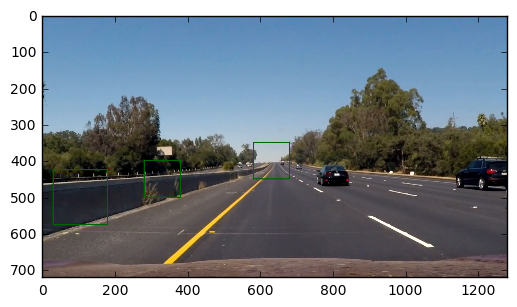

In [23]:
output = 'result_video.mp4'
clip1 = VideoFileClip("project_video.mp4")

clip = clip1.fl_image(check_for_car) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))